In [2]:
!pip install autogluon


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Import modules
import os
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from autogluon.tabular import TabularPredictor
from autogluon.common.space import Categorical, Real, Int


In [4]:
# Load and prepare data
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.DataFrame(data.target, columns=["target"])

In [5]:
# Split data (70% train, 10% val, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [6]:
# Defining Model
class IrisNN(nn.Module):
    def __init__(self):
        super(IrisNN, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 3)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [7]:
# Manual Training
def manual_train(batch_size, lr, epochs):
    model = IrisNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Convert data to tensors
    X_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_tensor = torch.tensor(y_train.values.flatten(), dtype=torch.long)

    # Store training history
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for i in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            outputs = model(X_tensor[i:i+batch_size])
            loss = criterion(outputs, y_tensor[i:i+batch_size])
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        history['train_loss'].append(epoch_loss/len(X_train))

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(torch.tensor(X_val.values, dtype=torch.float32))
            val_loss = criterion(val_outputs, torch.tensor(y_val.values.flatten(), dtype=torch.long))
            history['val_loss'].append(val_loss.item())

    # Test evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(torch.tensor(X_test.values, dtype=torch.float32))
        test_preds = torch.argmax(test_outputs, 1).numpy()

    return {
        'metrics': (accuracy_score(y_test, test_preds),
                   f1_score(y_test, test_preds, average='weighted')),
        'history': history,
        'model': model,
        'preds': test_preds
    }


In [8]:
# Run manual search (Grid Search)
manual_results = []
configs = [(bs, lr, ep) for bs in [2,4] for lr in [1e-3,1e-5] for ep in [1,3,5]]

for bs, lr, ep in configs:
    result = manual_train(bs, lr, ep)
    manual_results.append({
        'batch_size': bs,
        'lr': lr,
        'epochs': ep,
        'accuracy': result['metrics'][0],
        'f1': result['metrics'][1],
        'history': result['history'],
        'model': result['model'],
        'preds': result['preds']
    })

# Create comparison dataframe
manual_df = pd.DataFrame(manual_results)

In [9]:
# Performance for each hyperparameter combination over accuracy and F1.
acc_f1_df = pd.DataFrame([
    {
        'Batch Size': res['batch_size'],
        'Learning Rate': f"{res['lr']:.0e}",
        'Epochs': res['epochs'],
        'Accuracy': res['accuracy'],
        'F1 Score': res['f1']
    }
    for res in manual_results
])

print("\nHyperparameter Results Summary:")
acc_f1_df


Hyperparameter Results Summary:


,Batch Size,Learning Rate,Epochs,Accuracy,F1 Score
0,2,1e-03,1,0.366667,0.196748
1,2,1e-03,3,0.700000,0.593548
2,2,1e-03,5,0.700000,0.593548
3,2,1e-05,1,0.300000,0.138462
4,2,1e-05,3,0.333333,0.166667
5,2,1e-05,5,0.366667,0.196748
6,4,1e-03,1,0.300000,0.138462
7,4,1e-03,3,0.700000,0.593548
8,4,1e-03,5,0.700000,0.593548
9,4,1e-05,1,0.300000,0.138462


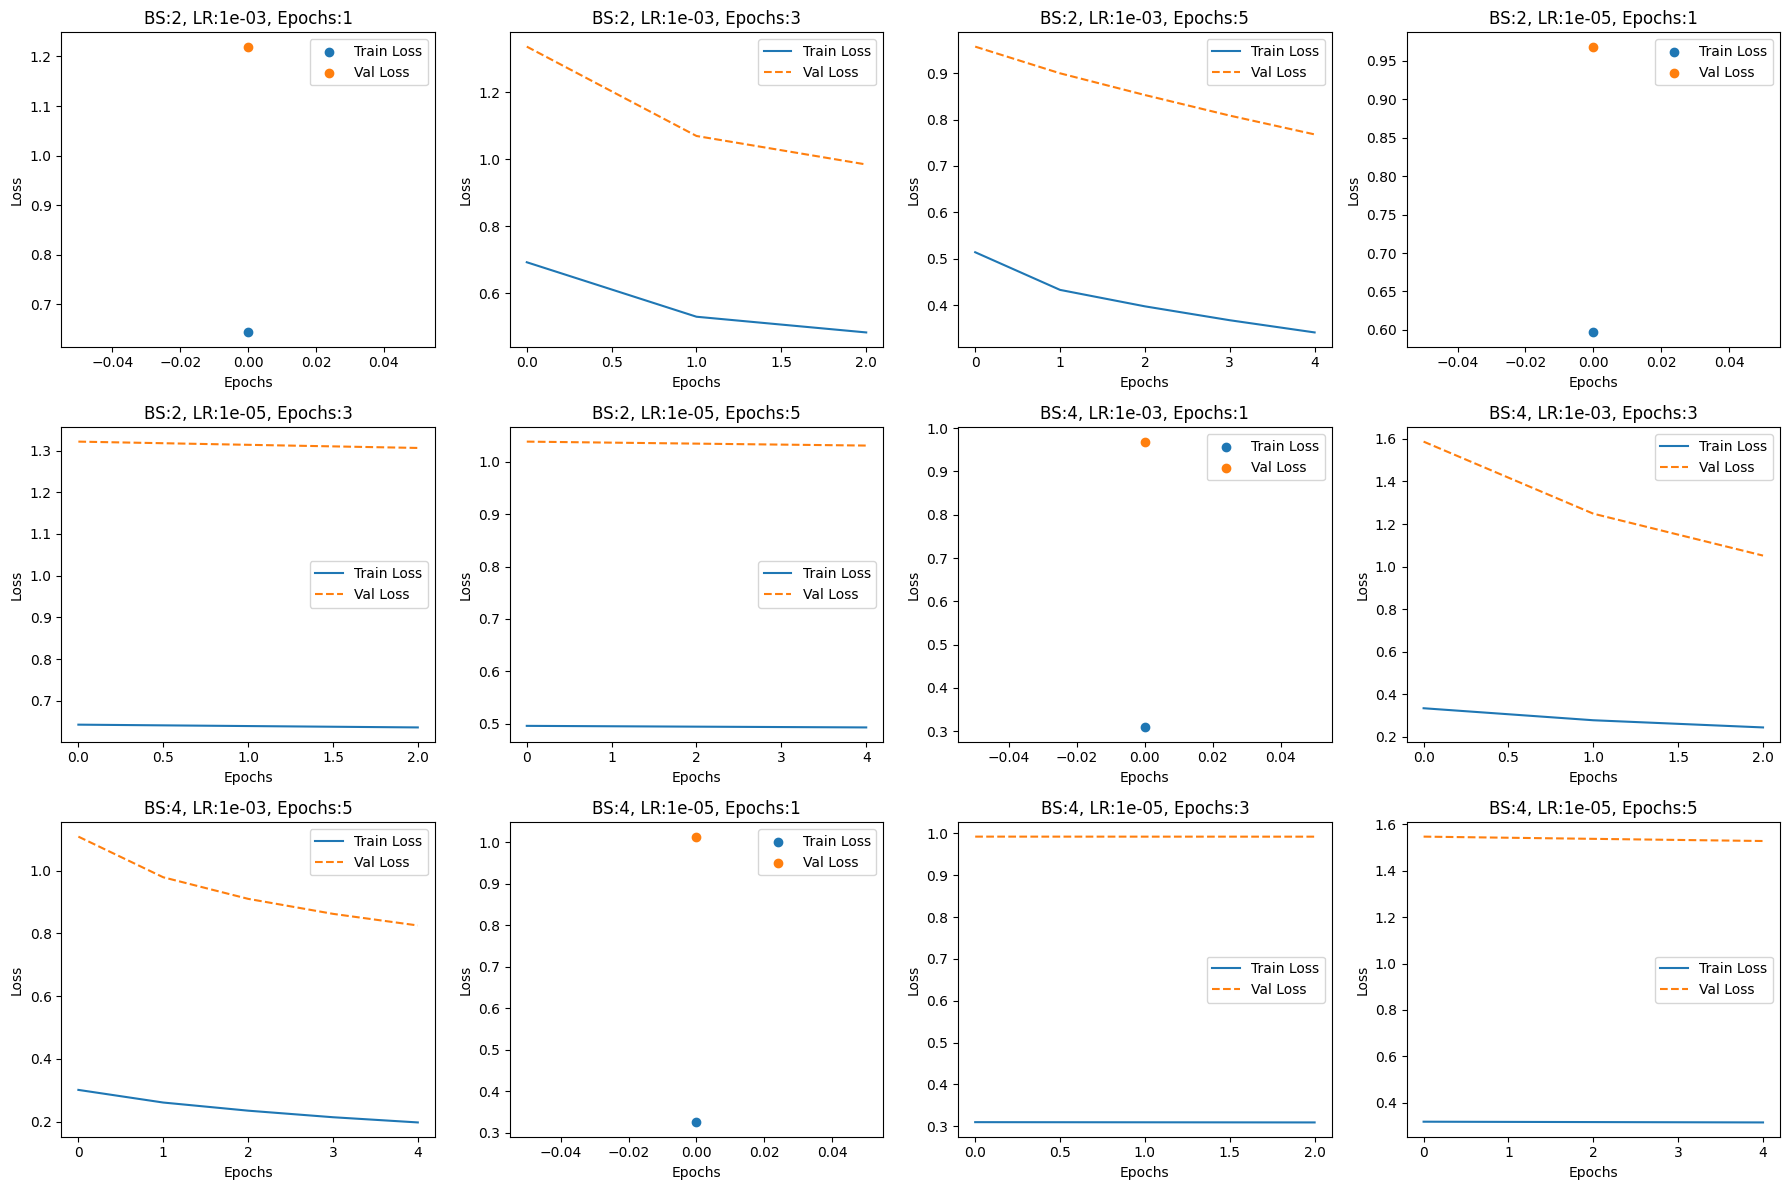

In [10]:
# Validation and Training Loss curves
plt.figure(figsize=(18, 12))

num_results = len(manual_results)

for i, res in enumerate(manual_results):
    if res['epochs'] == 1:
        plt.subplot(3, 4, i + 1)
        label = f"BS:{res['batch_size']}, LR:{res['lr']:.0e}, Epochs:{res['epochs']}"

        plt.scatter([0], res['history']['train_loss'], label='Train Loss')  # Scatter plot for only 1 epoch
        plt.scatter([0], res['history']['val_loss'], label='Val Loss')  # Scatter plot for only 1 epoch

        plt.title(label)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        continue

    plt.subplot(3, 4, i + 1)
    label = f"BS:{res['batch_size']}, LR:{res['lr']:.0e}, Epochs:{res['epochs']}"

    plt.plot(res['history']['train_loss'], label='Train Loss')
    plt.plot(res['history']['val_loss'], '--', label='Val Loss')

    plt.title(label)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

plt.tight_layout()
plt.show()

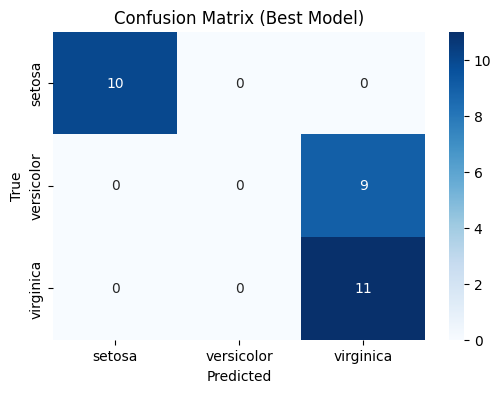

In [11]:
# Plot confusion matrix for best model
best_model = manual_df.loc[manual_df['f1'].idxmax()]
cm = confusion_matrix(y_test, best_model['preds'])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=data.target_names,
           yticklabels=data.target_names)
plt.title("Confusion Matrix (Best Model)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

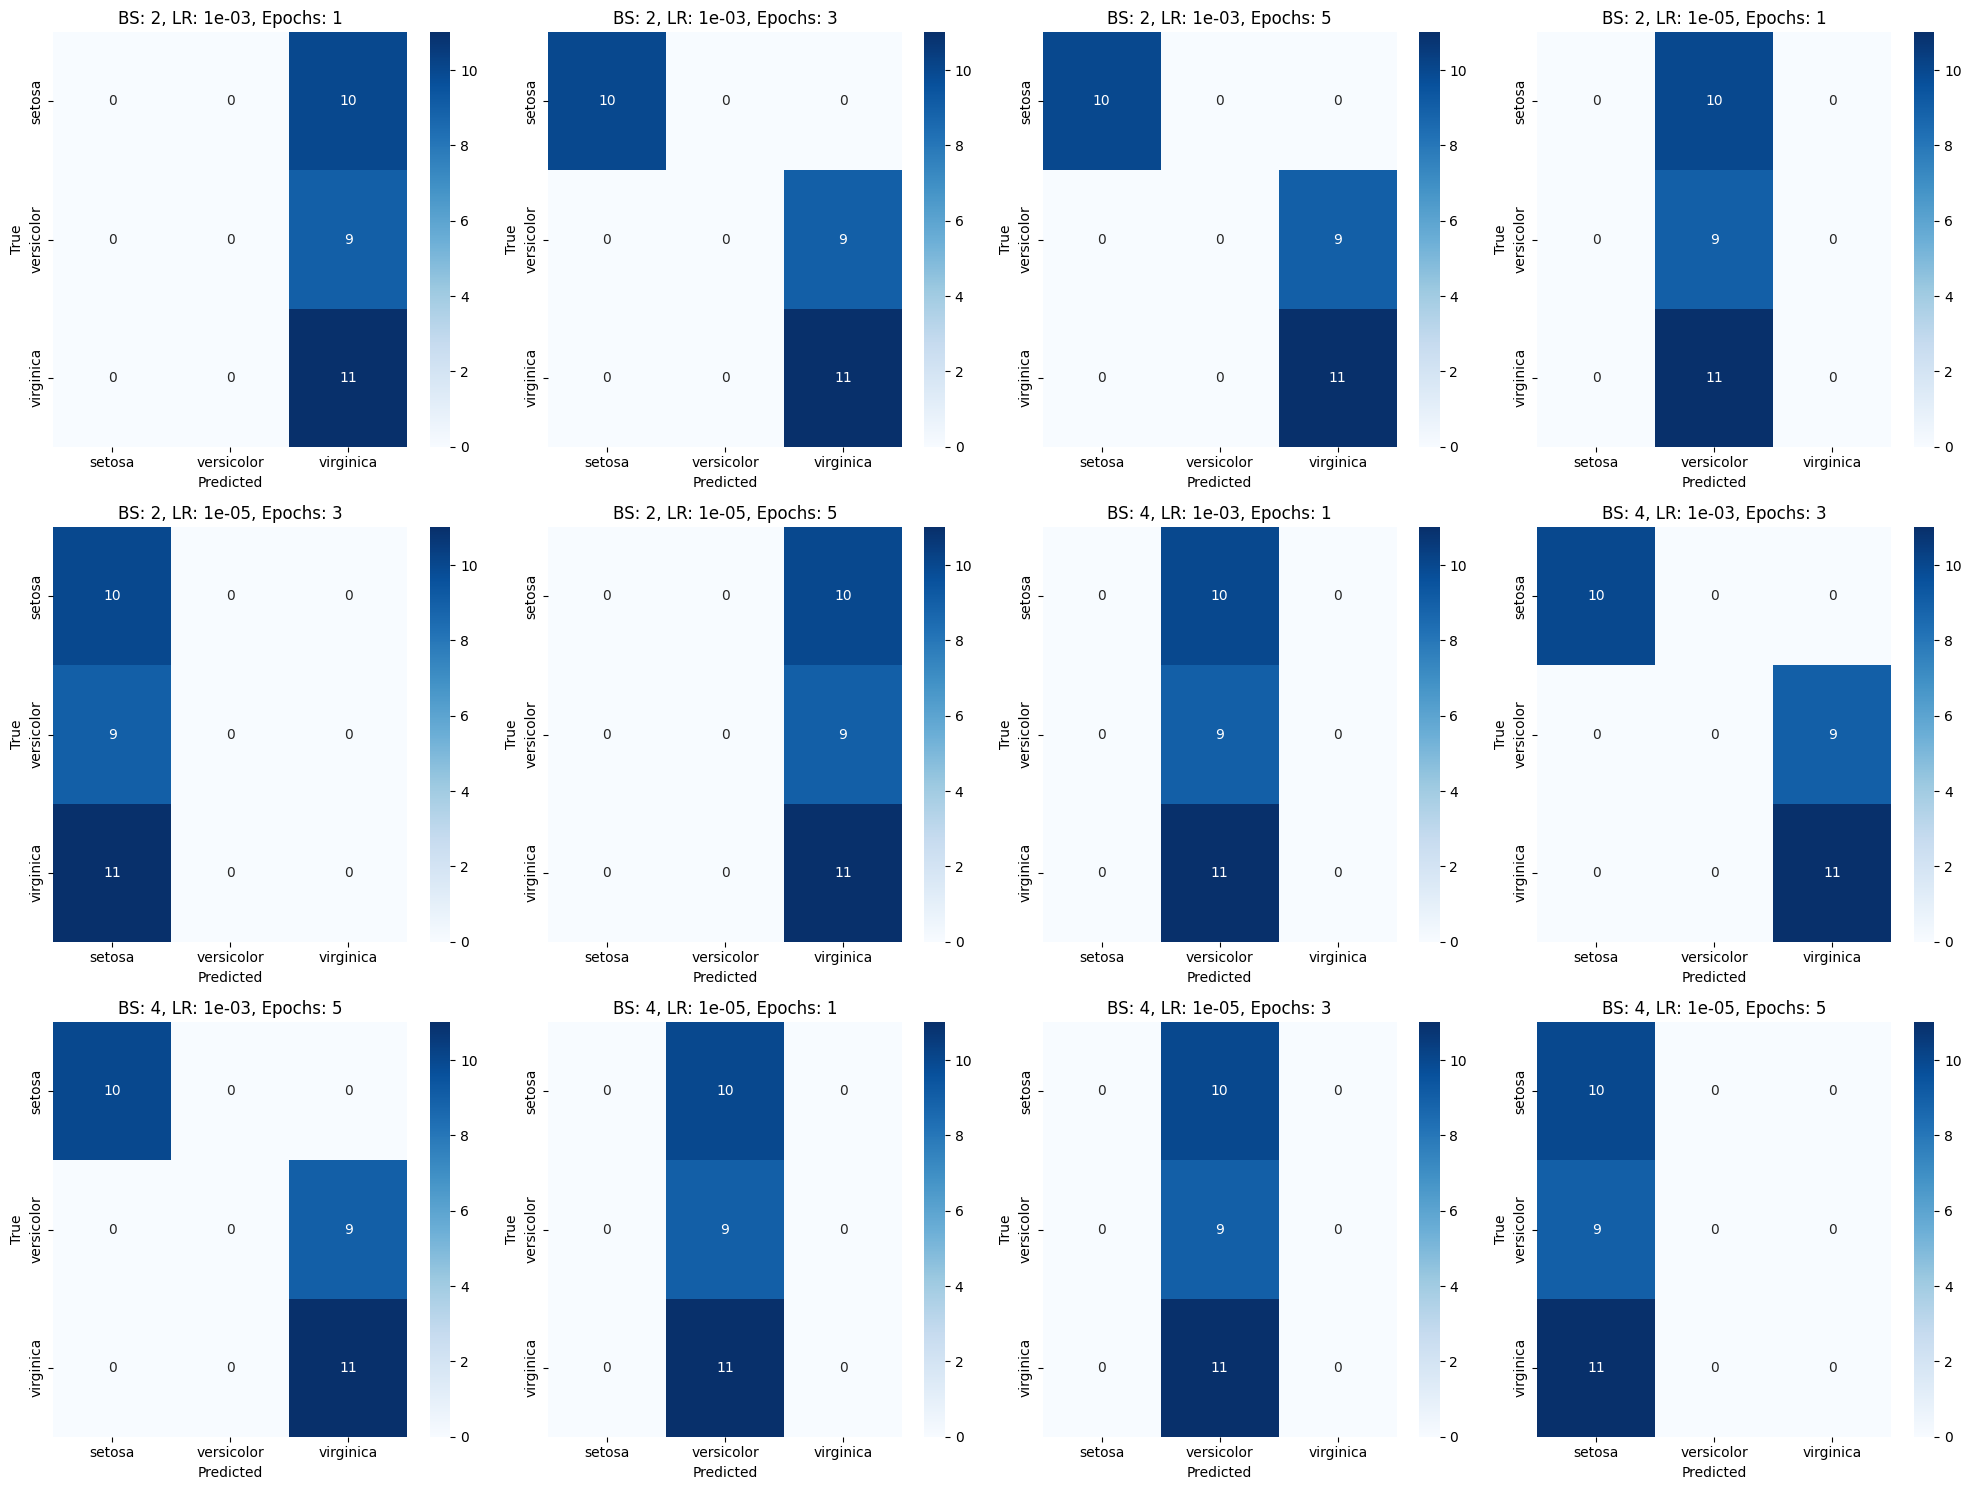

In [12]:
# Plot confusion matrices for all hyperparameter combinations
rows = 3
cols = 4

plt.figure(figsize=(cols * 5, rows * 5))

# Loop through each model result
for i, res in enumerate(manual_results):
    cm = confusion_matrix(y_test, res['preds'])

    plt.subplot(rows, cols, i + 1)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=data.target_names,
                yticklabels=data.target_names)

    plt.title(f"BS: {res['batch_size']}, LR: {res['lr']:.0e}, Epochs: {res['epochs']}")
    plt.xlabel("Predicted")
    plt.ylabel("True")

plt.tight_layout()
plt.show()

In [13]:
# Show 5 sample predictions for best model
sample_idx = np.random.choice(len(X_test), 5, replace=False)
print("\nSample Predictions:")
for idx in sample_idx:
    features = X_test.iloc[idx].values
    true = data.target_names[y_test.iloc[idx].values[0]]
    pred = data.target_names[best_model['preds'][idx]]
    print(f"Features: {features} | Predicted: {pred:8} | True: {true}")


Sample Predictions:
Features: [5.  3.4 1.6 0.4] | Predicted: setosa   | True: setosa
Features: [4.7 3.2 1.6 0.2] | Predicted: setosa   | True: setosa
Features: [5.7 3.8 1.7 0.3] | Predicted: setosa   | True: setosa
Features: [6.5 3.2 5.1 2. ] | Predicted: virginica | True: virginica
Features: [6.8 3.2 5.9 2.3] | Predicted: virginica | True: virginica


In [14]:
# Show 5 sample predictions for each model
print("\nSample Predictions for Each Model:\n")

for res in manual_results:
    print(f"\nModel - BS: {res['batch_size']}, LR: {res['lr']:.0e}, Epochs: {res['epochs']}\n")

    # Randomly select 5 test samples
    sample_idx = np.random.choice(len(X_test), 5, replace=False)

    for idx in sample_idx:
        features = X_test.iloc[idx].values
        true = data.target_names[y_test.iloc[idx].values[0]]
        pred = data.target_names[res['preds'][idx]]

        print(f"Features: {features} | Predicted: {pred:12} | True: {true}")



Sample Predictions for Each Model:


Model - BS: 2, LR: 1e-03, Epochs: 1

Features: [6.4 2.8 5.6 2.1] | Predicted: virginica    | True: virginica
Features: [6.2 2.2 4.5 1.5] | Predicted: virginica    | True: versicolor
Features: [6.4 2.8 5.6 2.2] | Predicted: virginica    | True: virginica
Features: [5.4 3.4 1.5 0.4] | Predicted: virginica    | True: setosa
Features: [4.7 3.2 1.6 0.2] | Predicted: virginica    | True: setosa

Model - BS: 2, LR: 1e-03, Epochs: 3

Features: [7.7 2.6 6.9 2.3] | Predicted: virginica    | True: virginica
Features: [4.9 3.1 1.5 0.1] | Predicted: setosa       | True: setosa
Features: [6.9 3.1 5.1 2.3] | Predicted: virginica    | True: virginica
Features: [4.7 3.2 1.6 0.2] | Predicted: setosa       | True: setosa
Features: [6.7 3.  5.2 2.3] | Predicted: virginica    | True: virginica

Model - BS: 2, LR: 1e-03, Epochs: 5

Features: [5.5 3.5 1.3 0.2] | Predicted: setosa       | True: setosa
Features: [6.4 2.8 5.6 2.1] | Predicted: virginica    | True: virginica

# Autogluon

In [21]:
import os
import shutil
import pandas as pd
from autogluon.tabular import TabularPredictor
from autogluon.common.space import Int, Real, Categorical
from sklearn.metrics import accuracy_score, f1_score

# AutoGluon search
def run_autogluon_search(method):
    try:
        hyperparams = {
            'NN_TORCH': {
                'num_epochs': Int(1, 3, 5),
                'learning_rate': Real(1e-5, 1e-3),
                'batch_size': Categorical(2, 4)
            }
        }

        path = f"{method}_model"
        if os.path.exists(path):
            shutil.rmtree(path)

        predictor = TabularPredictor(
            label="target",
            path=path,
            eval_metric='f1_weighted'
        ).fit(
            train_data=pd.concat([X_train, y_train], axis=1),
            tuning_data=pd.concat([X_val, y_val], axis=1),
            hyperparameters=hyperparams,
            hyperparameter_tune_kwargs={
                'num_trials': 5,
                'searcher': method,
                'scheduler': 'local'
            },
            time_limit=300
        )

        # Retrieve leaderboard
        leaderboard = predictor.leaderboard(silent=True)

        results = []
        best_model = None
        best_f1 = 0

        for _, row in leaderboard.iterrows():
            model_name = row['model']
            if "WeightedEnsemble" in model_name:
                continue  # Skip ensemble models

            model_info = predictor.info()['model_info'].get(model_name, {}).get('hyperparameters', {})
            if not model_info:  # Skip models without hyperparameter details
                continue  

            test_pred = predictor.predict(X_test)
            acc = accuracy_score(y_test, test_pred)
            f1 = f1_score(y_test, test_pred, average='weighted')

            # Track best model
            if f1 > best_f1:
                best_f1 = f1
                best_model = {
                    'num_epochs': model_info.get('num_epochs', 'N/A'),
                    'learning_rate': model_info.get('learning_rate', 'N/A'),
                    'batch_size': model_info.get('batch_size', 'N/A'),
                    'accuracy': acc,
                    'f1': f1
                }

            results.append({
                'num_epochs': model_info.get('num_epochs', 'N/A'),
                'learning_rate': model_info.get('learning_rate', 'N/A'),
                'batch_size': model_info.get('batch_size', 'N/A'),
                'accuracy': acc,
                'f1': f1
            })

        # Convert results to DataFrame
        results_df = pd.DataFrame(results)

        return results_df, best_model
    
    except Exception as e:
        print(f"{method} search failed: {str(e)}")
        return pd.DataFrame(columns=['num_epochs', 'learning_rate', 'batch_size', 'accuracy', 'f1']), None


In [ ]:
# Random Search 
random_results_df, random_result = run_autogluon_search('random')

print(random_results_df)
print("Best Model Configuration:", random_result)

Fitted model: NeuralNetTorch\a7784_00000 ...
	0.8667	 = Validation score   (f1_weighted)
	3.71s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch\a7784_00001 ...
	0.9348	 = Validation score   (f1_weighted)
	3.6s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch\a7784_00002 ...
	0.4879	 = Validation score   (f1_weighted)
	4.01s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch\a7784_00003 ...
	0.8044	 = Validation score   (f1_weighted)
	3.47s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: NeuralNetTorch\a7784_00004 ...
	0.795	 = Validation score   (f1_weighted)
	3.99s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 299.95s of the 290.33s of remaining time.
	Ensemble Weights: {'NeuralNetTorch\a7784_00001': 1.0}
	0.9348	 = Validation score   (f1_weighted)
	0.01s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluo

   num_epochs  learning_rate  batch_size  accuracy        f1
0           3       0.000500           4  0.966667  0.966411
1           5       0.000010           2  0.966667  0.966411
2           2       0.000617           4  0.966667  0.966411
3           3       0.000788           2  0.966667  0.966411
4           3       0.000925           2  0.966667  0.966411
Best Model Configuration: {'num_epochs': 3, 'learning_rate': 0.0005002140392410372, 'batch_size': 4, 'accuracy': 0.9666666666666667, 'f1': 0.9664109121909632}


In [23]:
# Bayesian Optimization
bayes_result_df, bayes_result = run_autogluon_search('bayes')

# Display results table and best model
print(bayes_result_df)
print("Best Model Configuration:", bayes_result)

Fitted model: NeuralNetTorch\dedb3365 ...
	0.8667	 = Validation score   (f1_weighted)
	3.45s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch\1c9f1849 ...
	0.7333	 = Validation score   (f1_weighted)
	3.41s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch\36f79bcc ...
	0.5889	 = Validation score   (f1_weighted)
	4.07s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch\5f04e3c0 ...
	0.9348	 = Validation score   (f1_weighted)
	3.31s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch\1e8ef6da ...
	1.0	 = Validation score   (f1_weighted)
	3.33s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 299.95s of the 272.98s of remaining time.
	Ensemble Weights: {'NeuralNetTorch\1e8ef6da': 1.0}
	1.0	 = Validation score   (f1_weighted)
	0.0s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, tot

   num_epochs  learning_rate  batch_size  accuracy       f1
0           3       0.000398           4  0.966667  0.96675
1           3       0.000833           2  0.966667  0.96675
2           5       0.000010           2  0.966667  0.96675
3           2       0.000310           2  0.966667  0.96675
4           3       0.000528           2  0.966667  0.96675
Best Model Configuration: {'num_epochs': 3, 'learning_rate': 0.00039800285175614923, 'batch_size': 4, 'accuracy': 0.9666666666666667, 'f1': 0.966750208855472}


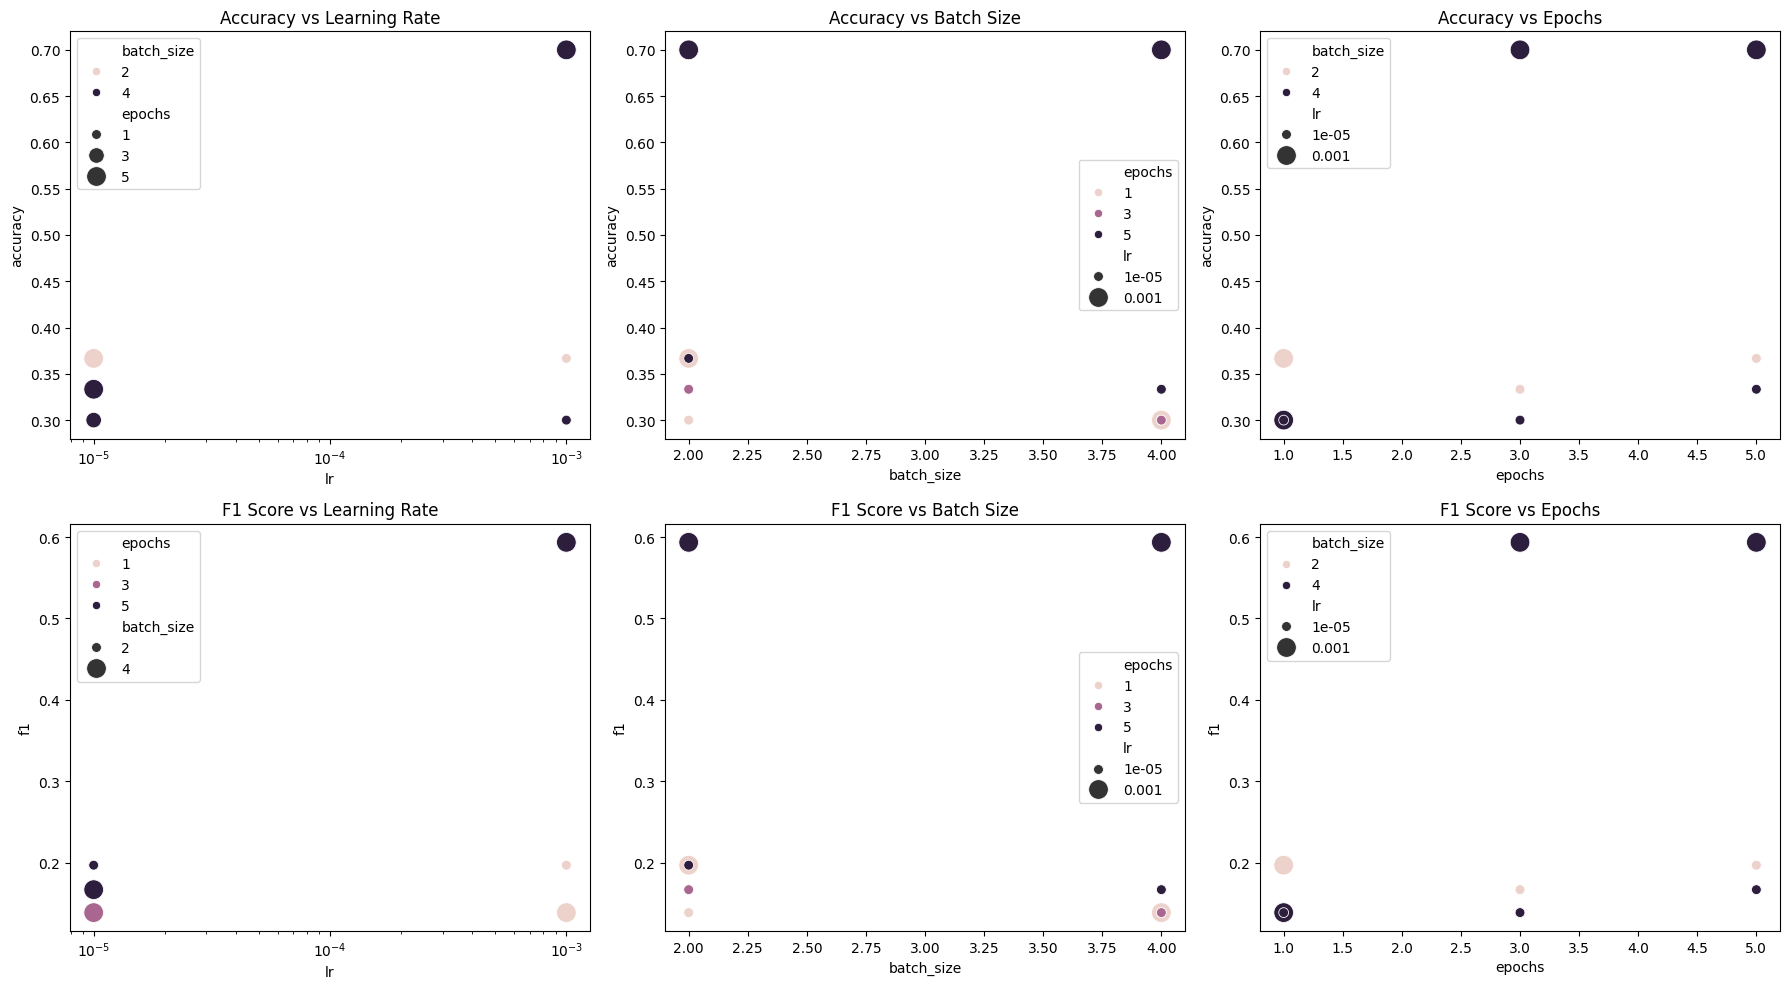

In [27]:
# Scatterplots to explore hyperparameter effects
plt.figure(figsize=(18, 10))

# Accuracy vs Learning Rate
plt.subplot(2,3,1)
sns.scatterplot(data=manual_df, x='lr', y='accuracy', hue='batch_size', size='epochs', sizes=(50, 200))
plt.xscale('log')  # Log scale for better LR visibility
plt.title("Accuracy vs Learning Rate")

# Accuracy vs Batch Size
plt.subplot(2,3,2)
sns.scatterplot(data=manual_df, x='batch_size', y='accuracy', hue='epochs', size='lr', sizes=(50, 200))
plt.title("Accuracy vs Batch Size")

# Accuracy vs Epochs
plt.subplot(2,3,3)
sns.scatterplot(data=manual_df, x='epochs', y='accuracy', hue='batch_size', size='lr', sizes=(50, 200))
plt.title("Accuracy vs Epochs")

# F1 Score vs Learning Rate
plt.subplot(2,3,4)
sns.scatterplot(data=manual_df, x='lr', y='f1', hue='epochs', size='batch_size', sizes=(50, 200))
plt.xscale('log')
plt.title("F1 Score vs Learning Rate")

# F1 Score vs Batch Size
plt.subplot(2,3,5)
sns.scatterplot(data=manual_df, x='batch_size', y='f1', hue='epochs', size='lr', sizes=(50, 200))
plt.title("F1 Score vs Batch Size")

# F1 Score vs Epochs
plt.subplot(2,3,6)
sns.scatterplot(data=manual_df, x='epochs', y='f1', hue='batch_size', size='lr', sizes=(50, 200))
plt.title("F1 Score vs Epochs")

plt.tight_layout()
plt.show()

In [25]:
# Final Comparison
comparison_data = {
    'Method': ['Manual Grid Search', 'Random Search', 'Bayesian Search'],
    'Accuracy': [manual_df['accuracy'].max(), random_result['accuracy'], bayes_result['accuracy']],
    'F1 Score': [manual_df['f1'].max(), random_result['f1'], bayes_result['f1']]
}
results_df = pd.DataFrame(comparison_data)
print("\nFinal Comparison:")
results_df


Final Comparison:


,Method,Accuracy,F1 Score
0,Manual Grid Search,0.700000,0.593548
1,Random Search,0.966667,0.966411
2,Bayesian Search,0.966667,0.966750


### **Analysis Based on Results**  

1. **Manual vs. Automated Search:** Manual Grid Search performed the worst (70% accuracy, 0.59 F1), showing its inefficiency in finding optimal hyperparameters.  

2. **Random vs. Bayesian Search:** Both achieved high accuracy (~96.67%), but Bayesian had a slightly better F1 score, indicating more balanced class predictions.  

3. **Why Bayesian Search Wins:** Bayesian optimization refines hyperparameters iteratively using prior evaluations, making it more efficient than purely random sampling.  

4. **Hyperparameter Impact:** Moderate epochs (2-3), a mid-range learning rate (~\(10^{-4}\)), and smaller batch sizes (2-4) led to the best performance.  

5. **Conclusion:** Bayesian Search is the best approach due to its data-driven exploration, but Random Search also performs well in finding optimal configurations.